In [64]:
import pandas as pd
import csv

from rich.console import Console
from rich.table import Table

from nltk.corpus import stopwords
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [65]:
rows = []

with open('data/SimpleDataset/raw-food.txt', 'r') as f:
    raw_food = f.read().splitlines()

    for line in raw_food:
        rows.append({
            'document': line.replace('"', ''),
            'class_name': 'food',
            'class_index': 0
        })

with open('data/SimpleDataset/raw-animal.txt', 'r') as f:
    raw_animal = f.read().splitlines()

    for line in raw_animal:
        rows.append({
            'document': line.replace('"', ''),
            'class_name': 'animal',
            'class_index': 1
        })

document_df = pd.DataFrame(rows)

# Preprocess
stop_words = stopwords.words('english')

document_df['document'] = document_df['document'].str.lower()
document_df['document'] = [re.sub(r'\W', ' ', x) for x in document_df['document']]
document_df['document'] = document_df['document'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Separate train and test
train_df = document_df.sample(frac=0.8, random_state=42)
train_df['dataset_type'] = 'train'

test_df = document_df.drop(train_df.index)
test_df['dataset_type'] = 'test'

document_df = pd.concat([train_df, test_df]).reset_index(drop=True)
document_df.to_csv('data/SimpleDataset/documents.csv', index=False, quoting=csv.QUOTE_NONE)

In [66]:
def print_table_dataset_infos(datasets_names: list):
    result_df = pd.DataFrame()

    for dataset_name in datasets_names:
        df = pd.read_csv(f'./data/{dataset_name}/documents.csv')

        number_documents = len(df)
        number_train_documents = len(df[df['dataset_type'] == 'train'])
        number_test_documents = len(df[df['dataset_type'] == 'test'])
        number_classes = len(set(df['class_name']))

        result_df = pd.concat([result_df, pd.DataFrame({
            'Dataset': [dataset_name],
            '# Documents': [number_documents],
            '# Train/Test Documents': [f'{number_train_documents}/{number_test_documents}'],
            '# Classes': [number_classes]
        })])

    console = Console()
    table = Table(title='Dataset infos')
    table.add_column('Dataset')
    table.add_column('# Documents')
    table.add_column('# Train/Test Documents')
    table.add_column('# Classes')
    
    for index, row in result_df.iterrows():
        table.add_row(row['Dataset'], str(row['# Documents']), str(row['# Train/Test Documents']), str(row['# Classes']))
    
    console.print(table)

    # print(result_df.to_latex(index=False))

In [67]:
print_table_dataset_infos(['SimpleDataset'])

                           Dataset infos                            
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Dataset       ┃ # Documents ┃ # Train/Test Documents ┃ # Classes ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ SimpleDataset │ 100         │ 80/20                  │ 2         │
└───────────────┴─────────────┴────────────────────────┴───────────┘

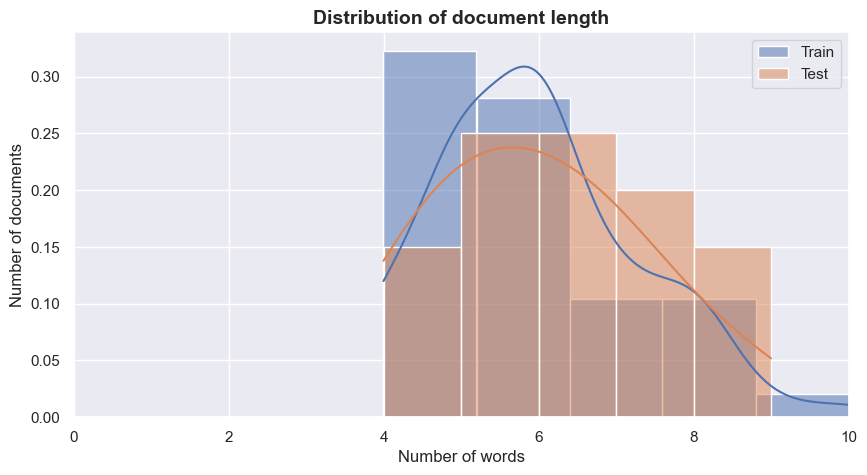

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

train_df = document_df[document_df['dataset_type'] == 'train']
test_df = document_df[document_df['dataset_type'] == 'test']

sns.histplot(train_df['document'].apply(lambda x: len(x.split())), bins=5, ax=ax, kde=True, stat='density', label='Train')
sns.histplot(test_df['document'].apply(lambda x: len(x.split())), bins=5, ax=ax, kde=True, stat='density', label='Test')

ax.set_title('Distribution of document length', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of words', fontsize=12)
ax.set_ylabel('Number of documents', fontsize=12)
ax.set_xlim(0, 10)
ax.legend()

fig.savefig('../figures/simple_dataset_document_length_distribution.png', dpi=300, bbox_inches='tight')

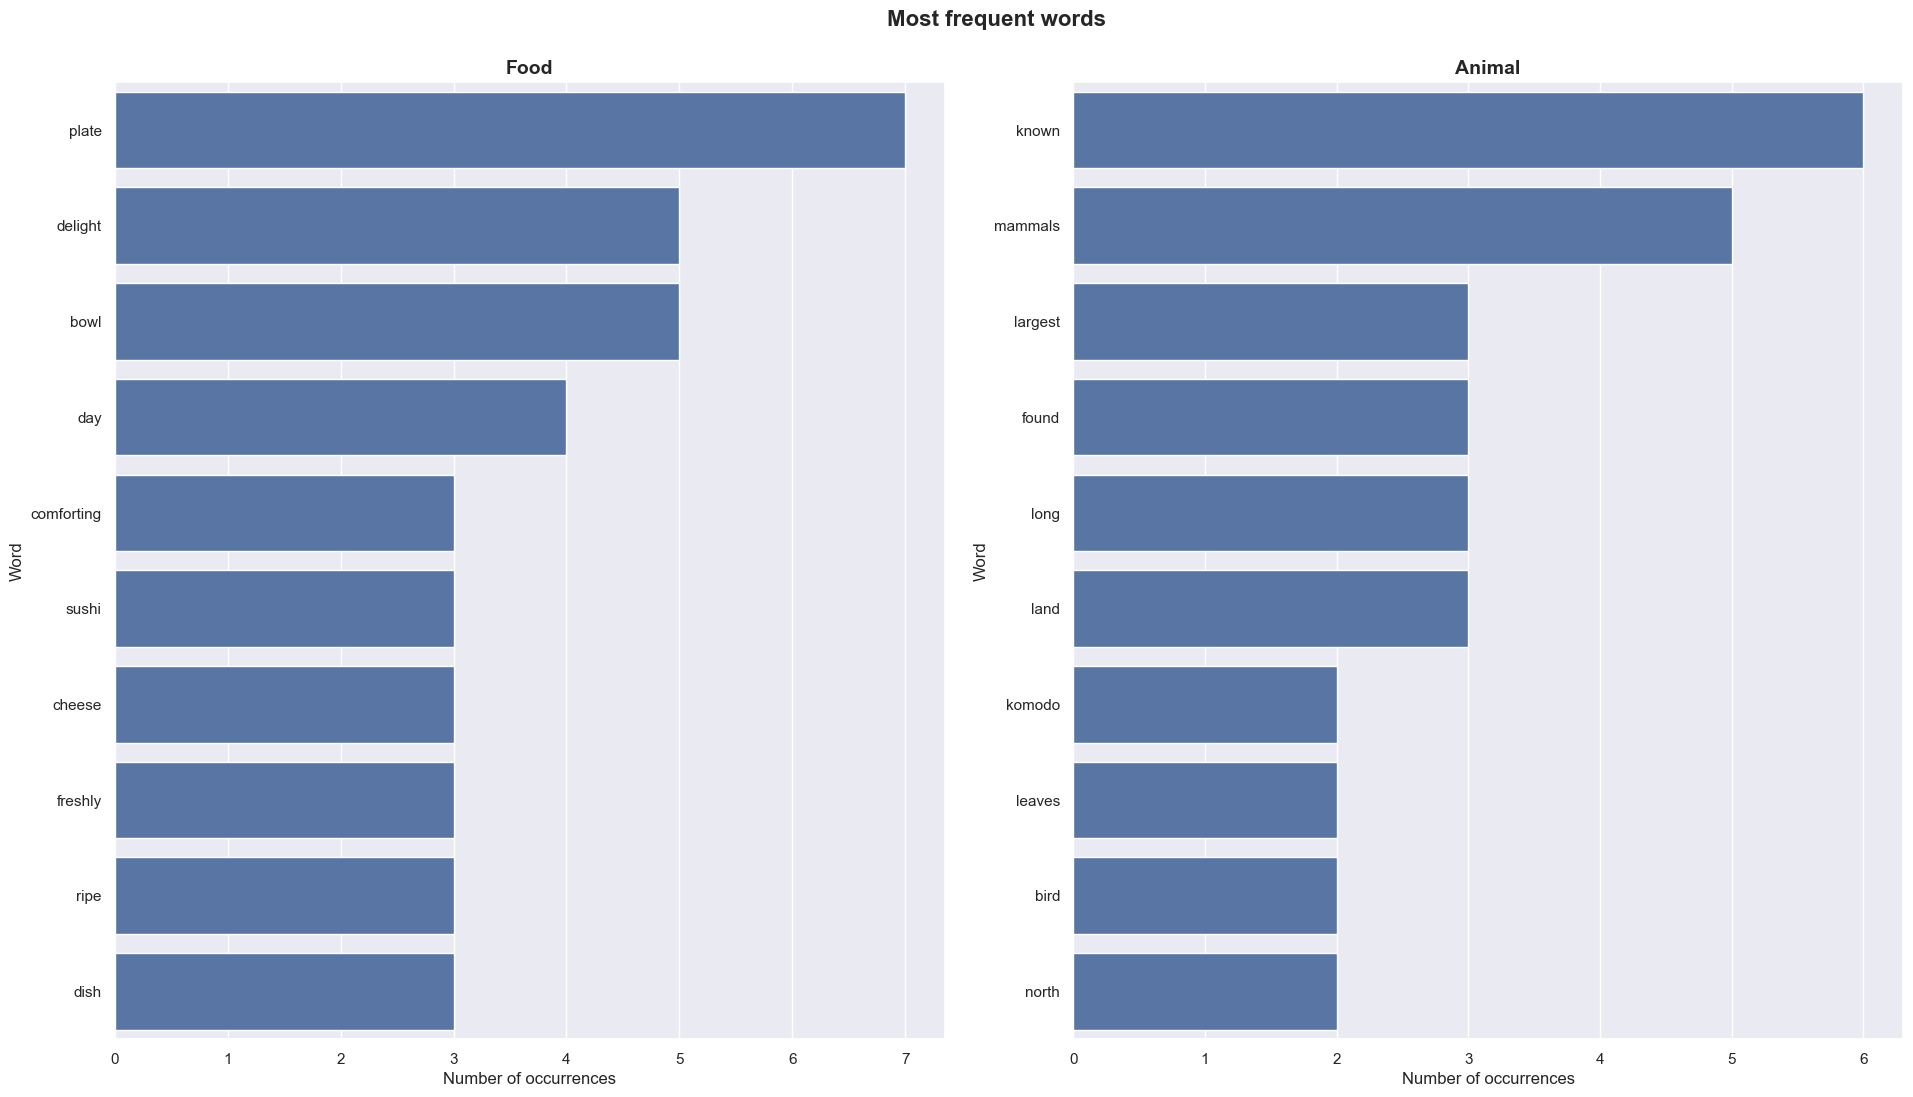

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
fig.suptitle('Most frequent words', fontsize=16, fontweight='bold')
fig.tight_layout(pad=5.0, rect=[0, 0.03, 1, 1.08])

for i, (dataset_part, dataset_part_name) in enumerate(zip([document_df[document_df['class_index'] == 0], document_df[document_df['class_index'] == 1]], ['Food', 'Animal'])):
    most_frequent_words = dataset_part['document'].str.split(expand=True).stack().value_counts()[:10].index.tolist()
    count_most_frequent_words = dataset_part['document'].str.split(expand=True).stack().value_counts()[:10].tolist()
    sns.barplot(y=most_frequent_words, x=count_most_frequent_words, ax=ax[i], orient='h', color='b')

    ax[i].set_title(f'{dataset_part_name}', fontsize=14, fontweight='bold')
    ax[i].set_xlabel('Number of occurrences', fontsize=12)
    ax[i].set_ylabel('Word', fontsize=12)

fig.savefig('../figures/simple_dataset_most_frequent_words.png', dpi=300, bbox_inches='tight')